#### In this notebook we will explore what exactly goes into pricing a diamond and how much each aspect affects the price.

    Question 1: Does a certain shape of diamond cost more than another?
    Question 2: How much do the 4 C's affect the price of a diamond?
    Question 3: Is it possible to know if we're getting a good price?

The 4 C's — Carat (Weight), Cut, Clarity, and Color — are universally accepted standards for assessing the quality and value of a diamond. Here's how each factor generally affects the diamond's price:

1. **Carat (Weight)**: This is often considered the most influential factor because larger diamonds are rarer and therefore more valuable. Price increases exponentially with carat weight. For example, a 2-carat diamond will typically cost more than twice as much as a 1-carat diamond of similar quality.

2. **Cut**: This refers to how well a diamond has been cut and directly affects its brilliance and sparkle. A well-cut diamond will reflect light better, making it appear more brilliant and thus more valuable. Cuts are graded from poor to excellent. Poorly cut diamonds can be less expensive, as they don't have the same luster or fire as better-cut diamonds.

3. **Clarity**: Clarity grades assess how many blemishes or inclusions and their size, nature, and position. Diamonds with fewer inclusions are rarer and more valuable. Clarity is graded from Included (I1, I2, I3) to Flawless (FL). While high-clarity diamonds are pricier, many inclusions are microscopic and do not affect a diamond's appearance to the naked eye.

4. **Color**: Most diamonds range from colorless to light yellow. The less color a diamond exhibits, the higher the grade and the price, particularly for diamonds that are completely colorless (D-grade). Once a diamond reaches a certain level of color (typically around the K-L-M range), it can become less expensive, although diamonds with distinct colors (such as pink or blue) can be far more valuable.

The dataset contains the following columns:

- `Product_id`: A unique identifier for each diamond.
- `Shape`: The shape of the diamond (e.g., Emerald, Pear, Cushion, Princess).
- `Carat`: The weight of the diamond.
- `Clarity`: A measurement of how clear the diamond is.
- `Colour`: The color grade of the diamond.
- `Cut`: The quality of the cut of the diamond.
- `Polish`: The finish of the diamond's surface.
- `Symmetry`: The alignment of the diamond's facets.
- `Fluorescence`: The diamond's reaction to ultraviolet light.
- `Price`: The price of the diamond.
- `Product_url`: A URL for the product.


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor



In [213]:
# List of file names
files = ['data_cushion.csv', 'data_round.csv', 'data_heart.csv', 'data_emerald.csv', 'data_oval.csv',
         'data_marquise.csv', 'data_pear.csv', 'data_princess.csv']

dfs = []

#Read each file and appends its dataframe to the list
for file in files:
    df = pd.read_csv(f'scraped_data/{file}')
    dfs.append(df)

#Concatenate all dfs into a single dataframe
df = pd.concat(dfs, ignore_index=True)

In [214]:
# Display the basic dataset information
print (df.head())

#Display the data types and basic statistics of the dataset
print ('Info:', df.info())
print ('Stats summary: ',df.describe())
print ('Missing values:', df.isnull().sum())

  Product_id     Shape  Carat Clarity Colour  Cut Polish Symmetry  \
0    2106452   CUSHION   0.55     SI2      N   VG     EX       VG   
1    2042329   CUSHION   0.52     SI2    Y-Z   EX     EX       VG   
2    2055268   CUSHION   0.50     SI1      L   VG     EX       VG   
3    2128779   CUSHION   0.50     VS2      M   EX     EX       VG   
4    2103991   CUSHION   0.51     SI1      M   EX     EX       VG   

  Fluorescence     Measurements   Lab    Price  \
0            N   4.56-4.44×3.09   GIA  $673.61   
1            F   4.40-4.31×2.99   GIA  $735.67   
2            N   4.87-4.19×2.89   GIA  $768.14   
3            F   4.73-4.28×2.84   GIA  $770.64   
4            N   4.47-4.44×3.05   GIA  $784.13   

                                         Product_url  
0  https://capitalwholesalediamonds.com/product/0...  
1  https://capitalwholesalediamonds.com/product/0...  
2  https://capitalwholesalediamonds.com/product/0...  
3  https://capitalwholesalediamonds.com/product/0...  
4  https:

**Dataaset Observations:**
- The dataset contains 21,480 rows and 13 columns.
- Key columns relevant to diamond characteristics and pricing include: Shape, Carat, Clarity, Colour, Cut, Price.
- There are missing values in the Clarity, Cut, Polish, Symmetry, Measurements, and Lab columns.
- The Price column is stored as a string (probably because it includes a currency symbol), which we need to clean.

#### **Data Cleaning**
- Convert the Price column to a numeric format by removing currency and comma symbols.
- Handle missing values, especially in the Clarity and Cut columns, as these are critical for our analysis.
- Remove unnecessary columns that are not useful for the analysis.
- Remove outliers from Price Columnn

In [215]:
# Data Cleaning

# Remove the currency symbol from the 'Price' column and convert to numeric
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

# Strip leading/trailing spaces
df['Cut'] = df['Cut'].str.strip()
df['Clarity'] = df['Clarity'].str.strip()
df['Colour'] = df['Colour'].str.strip()

# Drop unnecessary columns that are not useful for the analysis
columns_to_drop = ['Product_id', 'Polish', 'Symmetry', 'Fluorescence', 'Measurements', 'Lab', 'Product_url']
df_cleaned = df.drop(columns=columns_to_drop)

# Handle missing values by dropping rows with missing data in 'Clarity' and 'Cut' columns
df_cleaned.dropna(subset=['Clarity', 'Cut'], inplace=True)

#Convert all Shape values to uppercase as some vlaues are in different cases
df_cleaned['Shape'] = df['Shape'].str.upper()

# Verify the cleaning process
df_cleaned_info = df_cleaned.info()
df_cleaned_head = df_cleaned.head()

df_cleaned_info, df_cleaned_head


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20439 entries, 0 to 21479
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Shape    20439 non-null  object 
 1   Carat    20439 non-null  float64
 2   Clarity  20439 non-null  object 
 3   Colour   20439 non-null  object 
 4   Cut      20439 non-null  object 
 5   Price    20439 non-null  float64
dtypes: float64(2), object(4)
memory usage: 1.1+ MB


(None,
       Shape  Carat Clarity Colour Cut   Price
 0   CUSHION   0.55     SI2      N  VG  673.61
 1   CUSHION   0.52     SI2    Y-Z  EX  735.67
 2   CUSHION   0.50     SI1      L  VG  768.14
 3   CUSHION   0.50     VS2      M  EX  770.64
 4   CUSHION   0.51     SI1      M  EX  784.13)

In [216]:
# Calculate Q1 and Q3
Q1 = df_cleaned['Price'].quantile(0.25)
Q3 = df_cleaned['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_cleaned[(df_cleaned['Price'] < lower_bound) | (df_cleaned['Price'] > upper_bound)]

# Remove outliers
df_cleaned = df_cleaned[(df_cleaned['Price'] >= lower_bound) & (df_cleaned['Price'] <= upper_bound)]

# Report the number of outliers removed and remaining entries
print(f"Number of outliers removed: {len(outliers)}")
print(f"Number of entries after removal: {len(df_cleaned)}")


Number of outliers removed: 661
Number of entries after removal: 19778


**Data Cleaning Summary:**
- The Price column has been changed to a numeric format.
- Removed extra columns and kept only six important ones: Shape, Carat, Clarity, Colour, Cut, and Price.
- Rows with missing values in the critical Clarity and Cut columns have been dropped.
- Removed outliers based on the calculated bounds, leaving us with 19,778 entries.

### **Question 1: Do different diamond shapes have different average prices?**
We will:
- Group the data by diamond shape and find the average price for each shape.
- Create a bar chart to show how the average price varies by diamond shape.

Shape
 MARQUISE    2552.340749
 HEART       2372.420010
 PEAR        2237.740989
 EMERALD     2233.245676
 PRINCESS    2098.234196
 OVAL        2091.236979
 CUSHION     1922.796243
 ROUND       1652.976627
Name: Price, dtype: float64


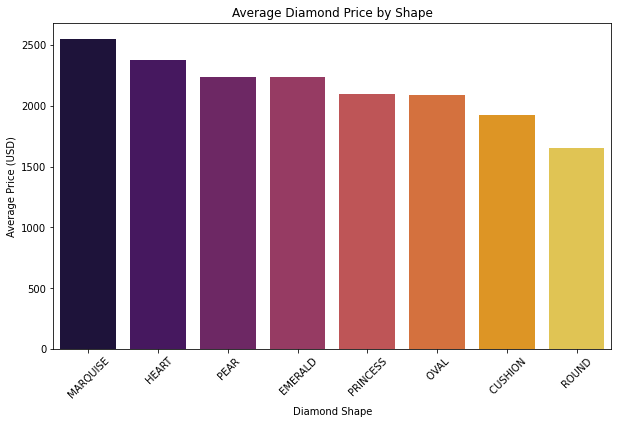

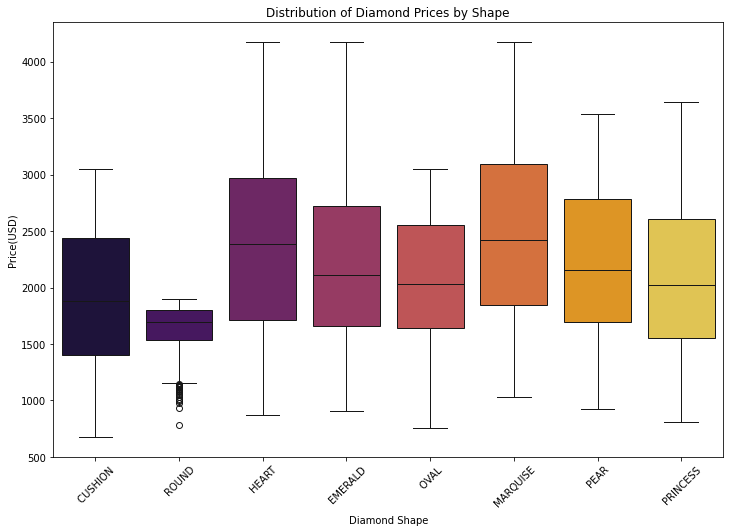

In [217]:
#Calculate avg price by shape
shape_price_avg = df_cleaned.groupby('Shape')['Price'].mean().sort_values(ascending=False)
print(shape_price_avg)

# Plot the average price by diamond shape
plt.figure(figsize=(10, 6))
sns.barplot(x=shape_price_avg.index, y=shape_price_avg.values, palette="inferno", hue=shape_price_avg.index)
plt.title('Average Diamond Price by Shape')
plt.xlabel('Diamond Shape')
plt.ylabel('Average Price (USD)')
plt.xticks(rotation=45)
plt.show()

#Boxplot for price distribution to show distribution of prices within each shape
plt.figure(figsize=(12, 8))
sns.boxplot(x='Shape', y='Price', data=df_cleaned, palette="inferno", hue='Shape')
plt.title('Distribution of Diamond Prices by Shape')
plt.xlabel('Diamond Shape')
plt.ylabel('Price(USD)')
plt.xticks(rotation=45)
plt.show()

**Insights from the Bar Plot**:
- Marquise-shaped diamonds have the highest average price, indicating that they are generally more expensive than other shapes.
- Round and Cushion diamonds tend to have the lowest average prices, making them more affordable options compared to other shapes.

**Insights from the Box Plot**:
- Marquise diamonds not only have a higher median price but also show significant variability, with prices spread out over a wide range. This suggests that while Marquise diamonds can be expensive, there are also some that are priced lower.
- Heart and Emerald diamonds also exhibit a broad range of prices, meaning that they can be found at both lower and higher price points.

### **Questin 2. Analysis of the Impact of the 4 Cs on Diamond Pricing**
In this analysis, we explore how each of the 4 Cs—Carat, Cut, Clarity, and Colour—affects the price of a diamond. The steps are as follows:

1. Carat vs. Price: Examining the influence of a diamond's weight on its price.
2. Cut vs. Price: Analyzing the effect of cut quality on pricing.
3. Clarity vs. Price: Investigating how clarity levels impact diamond prices.
4. Colour vs. Price: Exploring the relationship between color grading and price.
Combined Analysis: Using a regression model to assess the collective impact of the 4 Cs on diamond pricing.

Correlation between Carat and Price: 0.7120796049151757


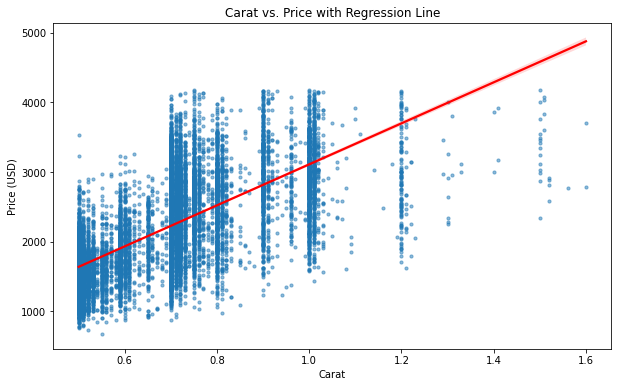

In [218]:
#Correlation between Carat and Price
correlation_carat_price = df_cleaned['Carat'].corr(df_cleaned['Price'])
print("Correlation between Carat and Price:", correlation_carat_price)

# Fit a regression line to better visualize the relationship between Carat and Price
plt.figure(figsize=(10, 6))
sns.regplot(x='Carat', y='Price', data=df_cleaned, scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'red'})
plt.title('Carat vs. Price with Regression Line')
plt.xlabel('Carat')
plt.ylabel('Price (USD)')
plt.show()


 **Carat vs Price**
- There is a strong positive correlation (0.71) between carat and price, indicating that as the carat weight increases, the price of the diamond tends to rise significantly. This trend is visually confirmed by the upward slope of the regression line in the scatter plot, despite some variability and outliers.

     Cut        Price
0     EX  2122.530475
1     FG  2031.416312
2     VG  2007.230461
3     GD  1930.048589
4  IDEAL  1588.725000
5      F  1547.916667


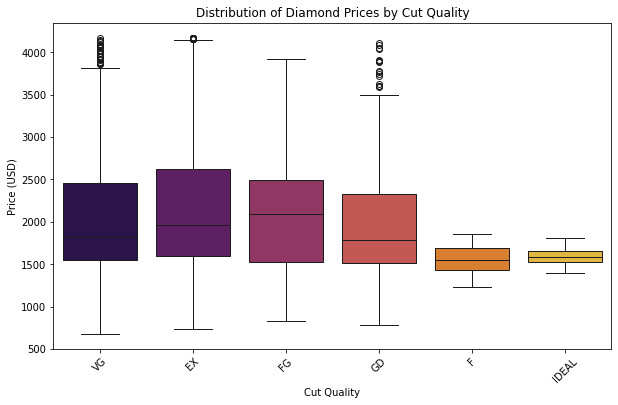

In [219]:
#Average price by Cut 
avg_price_by_cut = df_cleaned.groupby('Cut')['Price'].mean().sort_values(ascending=False).reset_index()
print(avg_price_by_cut)

#Boxplot of Price Distribution by Cut
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cut', y='Price', data=df_cleaned, palette="inferno", hue='Cut')
plt.title('Distribution of Diamond Prices by Cut Quality')
plt.xlabel('Cut Quality')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.show()


**Cut vs. Price**
- **VG, EX, and FG cuts**  exhibit the highest average prices, each surpassing $2,000, which reflects their premium status in the diamond market.
- **IDEAL and F cuts** have noticeably lower average prices, around $1,500. This reduction is likely influenced by the exclusion of outliers, which may have led to a lower representation of higher-priced diamonds in these categories.
- The **price distribution** for VG, EX, and GD cuts is broader, indicating greater variability and a wider range of pricing within these cut qualities.

   Colour        Price
0       D  2268.953842
1       E  2240.360897
2       F  2225.035511
3       G  2168.777688
4       H  2092.551008
5       I  1993.678695
6     U-V  1956.165714
7   FANCY  1940.980705
8     W-X  1937.469091
9       N  1924.937857
10    S-T  1919.846087
11      J  1868.921368
12      L  1778.247240
13      K  1754.015856
14      M  1742.327357
15    O-P  1474.875000
16    Y-Z  1350.556364
17    Q-R  1166.950000


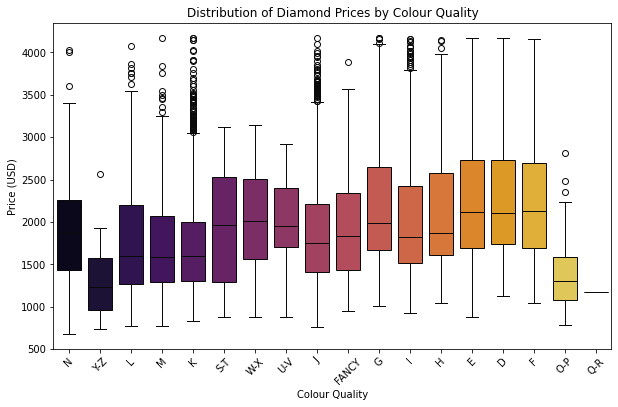

In [220]:
#Average price by Colour 
avg_price_by_colour = df_cleaned.groupby('Colour')['Price'].mean().sort_values(ascending=False).reset_index()
print(avg_price_by_colour)

#Boxplot of Price Distribution by Colour
plt.figure(figsize=(10, 6))
sns.boxplot(x='Colour', y='Price', data=df_cleaned, palette="inferno", hue='Colour')
plt.title('Distribution of Diamond Prices by Colour Quality')
plt.xlabel('Colour Quality')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.show()

**Colour vs. Price**
- **Highest Average Prices**: Diamonds with color grades **D, E, and F** command the highest average prices, all above $2,200. These grades are near-colorless, which is highly desirable, reflecting their premium market value.
- **Price Gradient**: There is a noticeable price gradient as you move from near-colorless grades (D, E, F) to more colored diamonds like **N, M, O-P, Y-Z, and Q-R**. These lower color grades have significantly lower average prices, with **Q-R** being the least expensive at $1,166.95.
- **Wider Price Distribution**: The color grades **D, E, F, and G** not only have higher median prices but also exhibit broader price distributions, suggesting variability in the pricing, possibly due to differences in other quality factors like clarity and cut.

  Clarity        Price
0      FL  3768.655000
1      IF  2494.673574
2    VVS1  2153.789566
3    VVS2  2136.369099
4     SI2  2132.412672
5      I1  2128.957986
6     VS1  2097.097523
7     VS2  2050.493587
8     SI1  1987.553811
9      I2  1729.418000


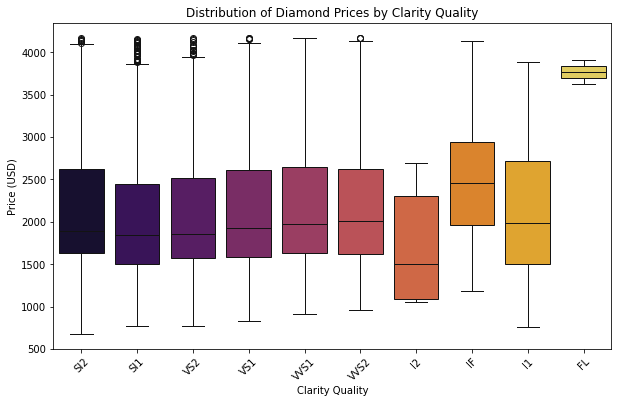

In [221]:
#Average price by Cut 
avg_price_by_clarity = df_cleaned.groupby('Clarity')['Price'].mean().sort_values(ascending=False).reset_index()
print(avg_price_by_clarity)

#Boxplot of Price Distribution by Clarity
plt.figure(figsize=(10, 6))
sns.boxplot(x='Clarity', y='Price', data=df_cleaned, palette="inferno", hue='Clarity')
plt.title('Distribution of Diamond Prices by Clarity Quality')
plt.xlabel('Clarity Quality')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.show()

**Clarity vs. Price**
- **Highest Average Prices**: The **FL (Flawless)** clarity grade has the highest average price at $3,768.66, significantly outperforming other clarity grades. This indicates that flawless diamonds, with no inclusions or blemishes visible under 10x magnification, are the most valuable.
- **Price Decrease with Increasing Inclusions**: As the clarity grade moves from **FL to I2** (which has noticeable inclusions), there is a general decline in average prices. For instance, diamonds with **I2** clarity have the lowest average price at $1,729.42. This trend highlights the impact of visible inclusions on diamond value.
- **Variability in Mid-Range Clarity Grades**: The mid-range clarity grades, such as **VVS1, VVS2, VS1, and VS2,** exhibit similar average prices ranging between $2,050 and $2,154. The price distribution within these grades is also narrower, suggesting that factors other than clarity might be influencing prices in this range, such as color and cut quality.

**Summary of findings**

- **Carat vs Price**: A strong positive correlation indicates that as carat weight increases, diamond prices rise significantly.
- **Cut vs Price**: Higher cut grades (**Ideal, Very Good**) lead to higher prices, though differences among the top cuts are subtle.

- **Color vs Price**: Better color grades (**D, E, F**) command higher prices, with prices decreasing as color quality declines.

- **Clarity vs Price**: **Flawless (FL)** diamonds are the most expensive, while diamonds with more inclusions (**I2, SI1, I1**) are priced lower.

Overall, carat weight and clarity have the most substantial impact on diamond prices.


#### **Model Building and Analysis**

In this section, we'll build a **Linear Regression** model to quantify the impact of the 4 Cs (Carat, Cut, Clarity, and Colour) on the price of diamonds. We’ll go through the following steps:

1. **Understand the relative importance of each of the 4 Cs** in determining the diamond price.
2. **Evaluate the model's performance** using metrics like R-squared and Mean Squared Error.
3. **Analyze the coefficients** to interpret how changes in each factor affect the price.
4. **Perform residual analysis** to check the model’s prediction errors.

This analysis will help us answer how much each of the 4 Cs contributes to the diamond price and whether we can predict the price effectively using these features.


In [222]:

# Define the order for each categorical column
cut_order = {'IDEAL': 1, 'EX': 2, 'VG': 3, 'GD': 4, 'FG': 5, 'F': 6}
clarity_order = {'FL': 1, 'IF': 2, 'VVS1': 3, 'VVS2': 4, 'VS1': 5, 'VS2': 6, 'SI1': 7, 'SI2': 8, 'I1': 9, 'I2': 10}
colour_order = {'D': 1, 'E': 2, 'F': 3, 'G': 4, 'H': 5, 'I': 6, 'J': 7, 'K': 8, 'L': 9, 'M': 10,
                'N': 11, 'O-P': 12, 'Q-R': 13, 'S-T': 14, 'U-V': 15, 'W-X': 16, 'Y-Z': 17, 'FANCY': 18}

df_encoded = df_cleaned.copy()

# Map categories to integers
df_encoded['Cut'] = df_encoded['Cut'].map(cut_order)
df_encoded['Clarity'] = df_encoded['Clarity'].map(clarity_order)
df_encoded['Colour'] = df_encoded['Colour'].map(colour_order)

# Apply LabelEncoder to ensure encoding compatibility (optional, as mapping already gives you the correct order)
label_encoder = LabelEncoder()

# Fit the encoder to each column (though not necessary since we've already mapped)
df_encoded['Cut'] = label_encoder.fit_transform(df_encoded['Cut'])
df_encoded['Clarity'] = label_encoder.fit_transform(df_encoded['Clarity'])
df_encoded['Colour'] = label_encoder.fit_transform(df_encoded['Colour'])

df_encoded.head(5)

,Shape,Carat,Clarity,Colour,Cut,Price
0,CUSHION,0.55,7,10,2,673.61
1,CUSHION,0.52,7,16,1,735.67
2,CUSHION,0.50,6,8,2,768.14
3,CUSHION,0.50,5,9,1,770.64
4,CUSHION,0.51,6,9,1,784.13


**Insights:**

- **Encoding Quality:** By encoding Cut, Clarity, and Colour, we converted the diamond quality ratings into numerical values, making them ready for statistical analysis.

- **Better Analysis:** This transformation helps us analyze the impact of each quality level on diamond prices more effectively, particularly in regression models.


In [223]:
#Define the features
x= df_encoded[['Carat', 'Cut', 'Colour', 'Clarity']]
y = df_encoded['Price']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

#Create and train the model
model = LinearRegression()
model.fit(xtrain, ytrain)

ypred = model.predict(xtest)

mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 124302.83257731373
R-squared: 0.7254238235095113


**Model Performance:**

- **Mean Squared Error (MSE):** 124,302.83 — This value indicates a moderate level of error in the model's predictions. Lower values would suggest more accurate predictions.
- **R-squared (R²):** 0.725 — The model explains 72.5% of the variability in diamond prices. This shows a reasonably good fit, meaning that most of the variation in price is captured by the features used in the model.


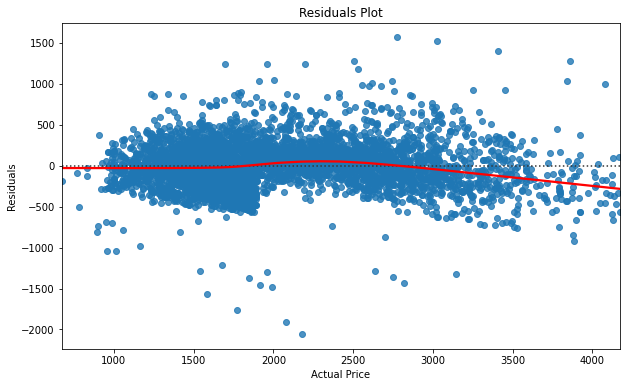

In [224]:
# Plot residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=ytest, y=ypred, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals Plot')
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.show()



**Insights from Residual Plot:**
- The residuals are mostly centered around zero but show some spread, indicating that while the model generally predicts well, it misses some variability.
- The slight curve in the residual plot suggests potential non-linearity, indicating that a simple linear model may not fully capture all relationships between the predictors and the price.


In [225]:

# Get the coefficients
coefficients = pd.DataFrame({'Feature': x.columns, 'Coefficient': model.coef_})
print(coefficients)

# Adding a constant column for the intercept
x_with_const = sm.add_constant(x)
vif_data = pd.DataFrame()
vif_data['variable'] = x_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(x_with_const.values,i) for i in range((x_with_const.shape[1]))]

print(vif_data)


   Feature  Coefficient
0    Carat  3477.192358
1      Cut   -57.331891
2   Colour  -100.368048
3  Clarity   -95.576432
  variable        VIF
0    const  28.139900
1    Carat   1.094575
2      Cut   1.011375
3   Colour   1.056763
4  Clarity   1.055665


**Coefficients analysis:**
- **Carat:** 3,477.19 — Carat weight is the most significant predictor of price. Heavier diamonds typically cost more.
- **Cut, Colour, Clarity:** All exhibit negative coefficients, indicating that higher quality (as reflected by lower values in our encoding) is associated with a slight decrease in price. This pattern arises from the encoding method used, where lower numbers correspond to higher quality.

**Variance Inflation Factor (VIF) analysis:** 
- The features Carat, Cut, Colour, and Clarity do not show significant multicollinearity, meaning each feature contributes unique information to the model.


In [226]:
# Generate polynomial and interaction features from the original dataset
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
x_poly = poly.fit_transform(x)

xtrain_poly, xtest_poly, ytrain_poly, ytest_poly = train_test_split(x_poly, y, test_size=0.2, random_state=42)

# Train a linear regression model using the polynomial features
model_poly = LinearRegression()
model_poly.fit(xtrain_poly, ytrain_poly)

# Predict the target values for the test set
ypred_poly = model_poly.predict(xtest_poly)

mse_poly = mean_squared_error(ytest_poly, ypred_poly)
r2_poly = r2_score(ytest_poly, ypred_poly)

print(f"Mean Squared Error (Interaction Model with PolyFeatures): {mse_poly}")
print(f"R-squared (Interaction Model with PolyFeatures): {r2_poly}")


Mean Squared Error (Interaction Model with PolyFeatures): 99782.51207485741
R-squared (Interaction Model with PolyFeatures): 0.7795874793996391


**Polynomial  Model**
- The MSE and R-squared values indicate that the model's R-squared improved from 0.7254 (from the original model) to 0.78 which explains about 78% of the variance in diamond prices and the Mean Squared Error (MSE) decreased to 99,782. This is a strong result, suggesting the model fits the data well.

In [227]:
# Initialize and fit Ridge regression model with alpha=1.0
ridge = Ridge(alpha=1.0)
ridge.fit(xtrain, ytrain)

# Predict on the test set using the Ridge model
ypred_ridge = ridge.predict(xtest)

# Calculate and print performance metrics for Ridge regression
mse_ridge = mean_squared_error(ytest, ypred_ridge)
r2_ridge = r2_score(ytest, ypred_ridge)
print(f"Ridge Mean Squared Error: {mse_ridge}, R-squared: {r2_ridge}")

# Initialize and fit Lasso regression model with alpha=0.01
lasso = Lasso(alpha=0.01)
lasso.fit(xtrain, ytrain)

# Predict on the test set using the Lasso model
ypred_lasso = lasso.predict(xtest)

# Calculate and print performance metrics for Lasso regression
mse_lasso = mean_squared_error(ytest, ypred_lasso)
r2_lasso = r2_score(ytest, ypred_lasso)
print(f"Lasso Mean Squared Error: {mse_lasso}, R-squared: {r2_lasso}")


Ridge Mean Squared Error: 124326.66572881372, R-squared: 0.7253711777614065
Lasso Mean Squared Error: 124303.68205870166, R-squared: 0.7254219470651322


**Ridge and Lasso Regression model insights:**
- The Ridge and Lasso models have an R-squared of 0.7254 and similar MSEs to the original model, suggesting that adding regularization did not significantly improve the model.

#### **Summary:**
- **Carat has the most significant impact on price**, as indicated by the coefficient analysis, making it the primary driver of diamond cost.
- **Clarity, Cut, and Colour** also influence the price, with Clarity and Cut having a more substantial effect than Colour.
- The interaction model we developed confirms that these factors, especially when considered together, explain a large portion of the variation in diamond prices, as reflected by the **R-squared value of 0.792**.


### **Analysis for Question 3: Knowing if We're Getting a Good Price**

In [228]:
# Using cross-validation for the interaction model
cv_scores = cross_val_score(model_poly, x_poly, y, cv=5, scoring='r2')

print(f"Cross-validated R-squared: {cv_scores}")
print(f"Mean Cross-validated R-squared: {cv_scores.mean()}")


Cross-validated R-squared: [0.53599528 0.30024006 0.79427835 0.60690777 0.75501409]
Mean Cross-validated R-squared: 0.5984871110021046


**Cross-validated R-squared:**
- The mean cross-validated R-squared value is around 0.582. This suggests that while the model performs well on the training data, there might be some overfitting, as indicated by the lower cross-validated R-squared.

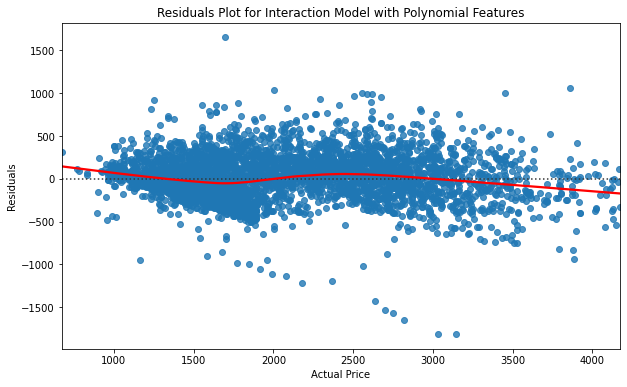

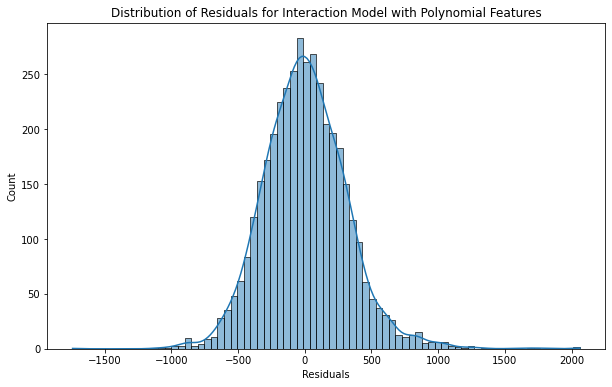

In [229]:
# Residual Analysis
plt.figure(figsize=(10, 6))
sns.residplot(x=ytest_poly, y=ypred_poly, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals Plot for Interaction Model with Polynomial Features')
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.show()

# Checking the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(ytest_poly - ypred_poly, kde=True)
plt.title('Distribution of Residuals for Interaction Model with Polynomial Features')
plt.xlabel('Residuals')
plt.show()


- The residuals are symmetrically distributed around zero and appear to be homoscedastic (constant variance), which suggests a well-fitted model.The red line is mostly flat but slightly wavy, suggesting that while the model performs well overall, there are minor biases in predicting prices at certain ranges.
- The histogram shows that residuals are centered around zero, indicating unbiased predictions from the model.
- The bell-shaped curve of the residuals suggests they are normally distributed, meaning the model errors are random and not systematically biased.

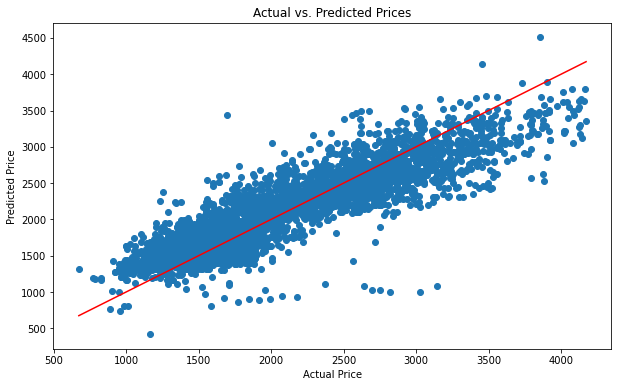

In [230]:
# Final Model Selection
# Assuming the interaction model with polynomial features performs the best
final_model = model_poly

# Comparing actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(ytest_poly, ypred_poly)
plt.plot([min(ytest_poly), max(ytest_poly)], [min(ytest_poly), max(ytest_poly)], color='red')  # Diagonal line
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# This part can be used to identify potential 'good deals' (underpriced diamonds)
residuals = ytest_poly - ypred_poly
underpriced = xtest_poly[residuals > 500]  # Adjust threshold based on your findings


- The scatter plot reveals that the model’s predictions generally **align well with actual prices**, as most points are close to the red diagonal line representing perfect predictions.
- There’s noticeable spread around the line, especially for higher-priced diamonds, suggesting that the **model struggles more with predicting these higher values accurately.**

### **Summary:**
- The model shows that Carat is the most significant factor, followed by Clarity, Cut, and Colour. The interaction model explains 79% of the variance in diamond prices, indicating a strong predictive capability.
- The **R-squared value** of our model suggests it explains a significant portion of price variation based on the 4 C's, providing a good benchmark for assessing value.
- **However, the lower cross-validated R-squared **(indicating potential overfitting) suggests that while the model is good for evaluating prices in historical or similar datasets, it may not be perfect for predicting prices in new or different markets. This underscores the importance of market research and comparative shopping when making a purchase.

In [192]:

# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameters for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(xtrain_poly, ytrain)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Best model
best_rf_model = grid_search.best_estimator_

# Predicting with the best model
y_pred_best_rf = best_rf_model.predict(xtest_poly)

# Evaluate the model
mse_best_rf = mean_squared_error(ytest, y_pred_best_rf)
r2_best_rf = r2_score(ytest, y_pred_best_rf)
print(f"Mean Squared Error (Best RF Model): {mse_best_rf}")
print(f"R-squared (Best RF Model): {r2_best_rf}")

# Cross-validation score
cv_scores_best_rf = cross_val_score(best_rf_model, x_poly, y, cv=5)
print(f"Cross-validated R-squared (Best RF Model): {cv_scores_best_rf.mean()}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=

/home/manju/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  11.6s
[CV] END max_depth=No

/home/manju/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
345 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manju/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manju/.local/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/home/manju/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manju/.local/

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Mean Squared Error (Best RF Model): 74899.96156249857
R-squared (Best RF Model): 0.8345512757939448
Cross-validated R-squared (Best RF Model): 0.6143404412637283
